In [117]:
#Import numpy
import numpy as np

#Import scikitlearn for machine learning functionalities
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits # For the UCI ML handwritten digits dataset

# Import matplotlib for plotting graphs ans seaborn for attractive graphics.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline

import seaborn as sb

import importlib
import os
os.environ['CUDA_VISIBLE_DEVICES']='4'

import argparse
import datetime
import json
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import datasets
import datasets.DAOD as DAOD
import util.misc as utils
import datasets.samplers as samplers
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
import models
from models import build_model

from config import get_cfg_defaults
from tqdm import tqdm

importlib.reload(models) # reload folder

<module 'models' from '/scratch2/users/cku/adaptation/AQT_subset/models/__init__.py'>

##  config set up

In [118]:
# best way is to modify all args to manual parameter

def setup(config_file):
    # initialise cfg from both defualt and the one defined by file
    cfg = get_cfg_defaults()
    
    if config_file:
        cfg.merge_from_file(config_file)
#     if opts:
#         cfg.merge_from_list(args.opts)
    utils.init_distributed_mode(cfg)
    cfg.freeze()
    
    # copy scripts to a specified dest
    if cfg.OUTPUT_DIR:
        Path(cfg.OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
        os.system(f'cp {config_file} {cfg.OUTPUT_DIR}')
        ddetr_src = 'models/deformable_detr.py'
        ddetr_des = Path(cfg.OUTPUT_DIR) / 'deformable_detr.py.backup'
        dtrans_src = 'models/deformable_transformer.py'
        dtrans_des = Path(cfg.OUTPUT_DIR) / 'deformable_transformer.py.backup'
        main_src = 'main.py'
        main_des = Path(cfg.OUTPUT_DIR) / 'main.py.backup'
        os.system(f'cp {ddetr_src} {ddetr_des}')
        os.system(f'cp {dtrans_src} {dtrans_des}')
        os.system(f'cp {main_src} {main_des}')

    return cfg

# write a name matching function, if names match named_params 
def match_name_keywords(n, name_keywords):
    out = False
    for b in name_keywords:
        if b in n:
            out = True
            break
    return out

In [119]:
# config_file = 'configs/r50_uda_c2fc.yaml'
config_file = 'configs/contrastive.yaml'

## load config file

In [120]:
cfg = setup(config_file)
# device
device = torch.device(cfg.DEVICE)

# fix the seed for reproducibility
seed = cfg.SEED + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Not using distributed mode


In [121]:
cfg.DEBUG # check debug mode

True

In [122]:
cfg.TRAIN.BATCH_SIZE, cfg.DATASET.NUM_CLASSES

(2, 4)

## build model

In [123]:
# build model
model, criterion, postprocessors, postprocessors_target = build_model(cfg)
model.to(device)
model_without_ddp = model

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [111]:
# for param in model_without_ddp.transformer.decoder.layers[0].parameters():
#     print(param.shape)

In [112]:
# model_without_ddp.transformer.decoder.layers.parameters()

## build data loader

In [124]:
# build coco detection dataset
dataset_val = build_dataset(image_set='val', cfg=cfg)

if cfg.DIST.DISTRIBUTED:
    if cfg.CACHE_MODE:
        sampler_val = samplers.NodeDistributedSampler(dataset_val, shuffle=False)
    else:
        sampler_val = samplers.DistributedSampler(dataset_val, shuffle=False)
else:
    sampler_val = torch.utils.data.SequentialSampler(dataset_val)
    
# the valid dataloder uses a sequential sampler
data_loader_val = DataLoader(dataset_val, cfg.TRAIN.BATCH_SIZE, sampler=sampler_val,
                             drop_last=False, collate_fn=utils.collate_fn, num_workers=cfg.NUM_WORKERS,
                             pin_memory=True)

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


## model paths

In [127]:
# model_path = 'exps/single_class/baseline/checkpoint0149.pth'
# model_path = 'exps/contrastive_subset/from_scratch_bs2/checkpoint0149.pth'
model_path = 'exps/contrastive_subset/all_class_contrastive/checkpoint0149.pth'
# model_path = 'exps/contrastive_subset/from_scratch_bs2/checkpoint0099.pth'
# model_path = "exps/contrastive_subset/bs2_resume_39/checkpoint0099.pth"

In [128]:
# load model weights
checkpoint = torch.load(model_path, map_location='cpu')
model_without_ddp.load_state_dict(checkpoint['model'], strict=False)

<All keys matched successfully>

## decoder embeddings

In [129]:
# get batch index and query index
def _get_src_permutation_idx(indices):
    # permute predictions following indices
    batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
    src_idx = torch.cat([src for (src, _) in indices])
    return batch_idx, src_idx

def _get_tgt_permutation_idx(indices):
    # permute targets following indices
    batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
    tgt_idx = torch.cat([tgt for (_, tgt) in indices])
    return batch_idx, tgt_idx

In [130]:
num_classes = 4

"""[{'id': 1, 'name': 'person'},
 {'id': 2, 'name': 'car'},
 {'id': 3, 'name': 'train'},
 {'id': 4, 'name': 'rider'},
 {'id': 5, 'name': 'truck'},
 {'id': 6, 'name': 'motorcycle'},
 {'id': 7, 'name': 'bicycle'},
 {'id': 8, 'name': 'bus'}]"""

"[{'id': 1, 'name': 'person'},\n {'id': 2, 'name': 'car'},\n {'id': 3, 'name': 'train'},\n {'id': 4, 'name': 'rider'},\n {'id': 5, 'name': 'truck'},\n {'id': 6, 'name': 'motorcycle'},\n {'id': 7, 'name': 'bicycle'},\n {'id': 8, 'name': 'bus'}]"

## tsne for decoder embeddings in the target domain only (bs=2)

In [131]:
model.eval() # set to eval mode to get both source and target labels

# length of dataloader is 250
target_features_1 = []
target_features_2 = []
target_features_new = []
tgt_label_1 = []
tgt_label_2 = []
tgt_label_new = []

# data and labels for inference
for samples, targets in tqdm(data_loader_val, desc='running inference'):
    samples = samples.to(device)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    outputs = model(samples, targets) # in debug mode, outputs would be a tuple
    out, backbone_feat, encoder_out, decoder_out = outputs # decoder_out: torch.Size([6, 2, 300, 256])

    loss_dict, indices = criterion(out, targets)

    # get matched query gt indices
    idx = _get_src_permutation_idx(indices)
    target_classes = torch.full((2,300), num_classes,
                                dtype=torch.int64, device=out['pred_logits'].device)

    
    # all class labels across all samples within a batch
    target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
    target_classes[idx] = target_classes_o

    # torch.Size([300])
    target_label_1 = target_classes[0]
    target_label_2 = target_classes[1]
#     import pdb; pdb.set_trace()
    
    # exclude background
    tgt_query_pos_1 = torch.where(target_label_1!=num_classes)
    tgt_query_pos_2 = torch.where(target_label_2!=num_classes)
    
    # get list of labels
    target_gt_1 = target_label_1[tgt_query_pos_1]
    target_gt_2 = target_label_2[tgt_query_pos_2]
    
    # filter class that has too many data points
    target_gt_1_idx = torch.where(target_gt_1!=1)
    target_gt_1_new = target_gt_1[target_gt_1_idx]
    
    # get src query embeddings
    target_out_1 = torch.index_select(decoder_out[-1][0], 0, tgt_query_pos_1[0]) #tgt_query_pos_1 is a tuple, thus need to index element
    target_out_1_new = torch.index_select(decoder_out[-1][0], 0, target_gt_1_idx[0])
    target_out_2 = torch.index_select(decoder_out[-1][0], 0, tgt_query_pos_2[0]) # selected query outputs

    # accumulate for all samples
    target_features_1.extend(target_out_1.cpu().detach().numpy())
    target_features_new.extend(target_out_1_new.cpu().detach().numpy())
    target_features_2.extend(target_out_2.cpu().detach().numpy())
    
    # accumulate for all samples
    tgt_label_1.extend(target_gt_1.cpu().detach().numpy())
    tgt_label_2.extend(target_gt_2.cpu().detach().numpy())
    tgt_label_new.extend(target_gt_1_new.cpu().detach().numpy())

target_features_1 = np.stack(target_features_1)
target_features_2 = np.stack(target_features_2)
target_features_new = np.stack(target_features_new)
tgt_label_1 = np.stack(tgt_label_1)
tgt_label_2 = np.stack(tgt_label_2)
tgt_label_new = np.stack(tgt_label_new)

running inference:   0%|                                                                                          | 0/243 [00:00<?, ?it/s]/scratch2/users/cku/adaptation/AQT_subset/models/position_encoding.py:53: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
running inference: 100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:37<00:00,  6.52it/s]


In [35]:
# obtained features and labels
target_features_1[0].shape, target_features_2[0].shape
len(target_features_1), len(target_features_2)

(2326, 2317)

In [136]:
from itertools import groupby

# check lengths
sum([len(list(group)) for key, group in groupby(sorted(tgt_label_1))])
len([len(list(group)) for key, group in groupby(sorted(tgt_label_1))])
len(target_features_1), len(tgt_label_1), len(target_features_2), len(tgt_label_2)

(2586, 2586, 2556, 2556)

In [137]:
[len(list(group)) for key, group in groupby(sorted(tgt_label_1))]

[2254, 284, 48]

In [53]:
for key, group in groupby(sorted(tgt_label_1)):
    print(len(list(group)))

2262
15
49


In [37]:
# merge prototypes into tsne features
# target_features_1 = torch.cat([source_features, prototypes[0]])
# target_features_2 = torch.cat([target_features, prototypes[1]])

In [145]:
# train tsne
tsne_tgt_new = TSNE(n_components=2).fit_transform(target_features_new)

/scratch2/users/cku/anaconda3/envs/deformable_detr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/scratch2/users/cku/anaconda3/envs/deformable_detr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
tsne_tgt_2 = TSNE(n_components=2).fit_transform(target_features_2)

In [142]:
# scale and move the coordinates so they fit [0; 1] range

def scale_to_01_range(x):

    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

   # move the distribution so that it starts from zero
   # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range

    return starts_from_zero / value_range

## tsne on tgt query embeddings

In [69]:
tsne_tgt_1.shape, tsne_tgt_2.shape

NameError: name 'tsne_tgt_1' is not defined

In [70]:
tsne_tgt_new.shape

(332, 2)

In [146]:
# get values for x and y
tx_tgt = tsne_tgt_new[:, 0]
ty_tgt = tsne_tgt_new[:, 1]

# scale to range between 0 and 1
tx_tgt = scale_to_01_range(tx_tgt)
ty_tgt = scale_to_01_range(ty_tgt)

## baseline

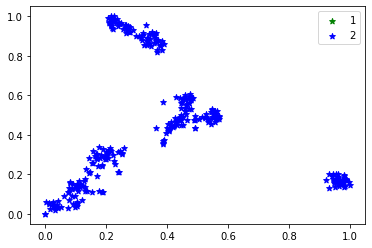

In [138]:
# define an extra label for prototype tokens
# colors_per_class = {'0': 'r', '1': 'g', '2': 'b',
#           '3':'c', '4': 'm', '5': 'y',
#                     '6':'k', '7':'pink', '8':'w'}


colors_per_class = {'1': 'g', '2': 'b'}

# fir distinuishing decoder embeddings and prototypes 
marker = ['*', '^']

# need to use a different marker for prototype tokens

labels = []

# need to know what labels are assigned to each feature in order to plot them
fig = plt.figure()
ax = fig.add_subplot(111)

# plot a cluster one by one
for label in colors_per_class:
    
    if label != '4':
        # find all indices of the current label
        indices = [i for i, l in enumerate(tgt_label_new) if str(l) == label]
        # use the indices of the current label to index the corresponding feature embeddings
        current_tx = np.take(tx_tgt, indices)
        current_ty = np.take(ty_tgt, indices)
    
        # add a scatter plot with the corresponding color and label
        ax.scatter(current_tx, current_ty, marker=marker[0], c=colors_per_class[label], label=label)
    else:
        indices = [i for i, l in enumerate(tgt_label_new) if str(l) == label]
        # use the indices of the current label to index the corresponding feature embeddings
        current_tx = np.take(tx_tgt, indices)
        current_ty = np.take(ty_tgt, indices)
    
        # add a scatter plot with the corresponding color and label
        ax.scatter(current_tx, current_ty, marker=marker[1], c=colors_per_class[label], label=label)
        

    
# build a legend using the labels we set previously
ax.legend(loc='best')
# finally, show the plot
plt.show()

## contrastive learning

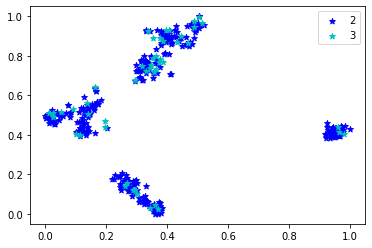

In [147]:
# define an extra label for prototype tokens
# colors_per_class = {'0': 'r', '1': 'g', '2': 'b',
#           '3':'c', '4': 'm', '5': 'y',
#                     '6':'k', '7':'pink', '8':'w'}

# specify the actual class labels
colors_per_class = {'2': 'b',
          '3':'c'}

# fir distinuishing decoder embeddings and prototypes 
marker = ['*', '^']

# need to use a different marker for prototype tokens

labels = []

# need to know what labels are assigned to each feature in order to plot them
fig = plt.figure()
ax = fig.add_subplot(111)

# plot a cluster one by one
for label in colors_per_class:
    
    if label != '4':
        # find all indices of the current label
        indices = [i for i, l in enumerate(tgt_label_new) if str(l) == label]
        # use the indices of the current label to index the corresponding feature embeddings
        current_tx = np.take(tx_tgt, indices)
        current_ty = np.take(ty_tgt, indices)
    
        # add a scatter plot with the corresponding color and label
        ax.scatter(current_tx, current_ty, marker=marker[0], c=colors_per_class[label], label=label)
        
# build a legend using the labels we set previously
ax.legend(loc='best')
# finally, show the plot
plt.show()

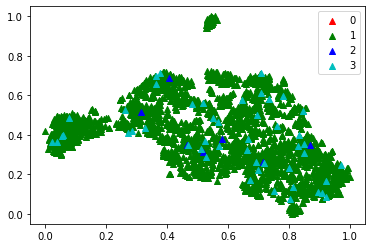

In [49]:
# define an extra label for prototype tokens
# colors_per_class = {'0': 'r', '1': 'g', '2': 'b',
#           '3':'c', '4': 'm', '5': 'y',
#                     '6':'k', '7':'pink', '8':'w'}


colors_per_class = {'0': 'r', '1': 'g', '2': 'b',
          '3':'c'}

# fir distinuishing decoder embeddings and prototypes 
marker = ['^']

# need to use a different marker for prototype tokens

labels = []

# need to know what labels are assigned to each feature in order to plot them
fig = plt.figure()
ax = fig.add_subplot(111)

# plot a cluster one by one
for label in colors_per_class:
    
    if label != '8':
        # find all indices of the current label
        indices = [i for i, l in enumerate(tgt_label_2) if str(l) == label]
        # use the indices of the current label to index the corresponding feature embeddings
        current_tx = np.take(tx_tgt, indices)
        current_ty = np.take(ty_tgt, indices)
    
        # add a scatter plot with the corresponding color and label
        ax.scatter(current_tx, current_ty, marker=marker[0], c=colors_per_class[label], label=label)
    else:
        indices = [i for i, l in enumerate(tgt_label_2) if str(l) == label]
        # use the indices of the current label to index the corresponding feature embeddings
        current_tx = np.take(tx_tgt, indices)
        current_ty = np.take(ty_tgt, indices)
    
        # add a scatter plot with the corresponding color and label
        ax.scatter(current_tx, current_ty, marker=marker[1], c=colors_per_class[label], label=label)
        

    
# build a legend using the labels we set previously
ax.legend(loc='best')
# finally, show the plot
plt.show()

In [71]:
tgt_label_1.shape, tgt_label_2.shape

((2326,), (2317,))

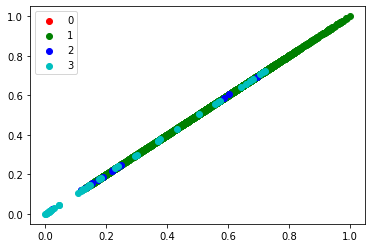

In [76]:
# plot both graphs since bs=2
colors_per_class = {'0': 'r', '1': 'g', '2': 'b',
          '3':'c', '4': 'm', '5': 'y',
                    '6':'k', '7':'pink'}

colors_per_class = {'0': 'r', '1': 'g', '2': 'b',
          '3':'c'}

labels = []

# need to know what labels are assigned to each feature in order to plot them
fig = plt.figure()
ax = fig.add_subplot(111)


# plot a cluster one by one
for label in colors_per_class:
    # find all indices of the current label
    indices = [i for i, l in enumerate(tgt_label_1) if str(l) == label]
    # use the indices of the current label to index the corresponding feature embeddings
    current_tx = np.take(tx_tgt, indices)
    current_ty = np.take(ty_tgt, indices)
    
#     import pdb; pdb.set_trace()

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=colors_per_class[label], label=label)
    
    
# build a legend using the labels we set previously
ax.legend(loc='best')
# finally, show the plot
plt.show()

## plot memory embeddings

In [ ]:
# scale and move the coordinates so they fit [0; 1] range

def scale_to_01_range(x):

    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

   # move the distribution so that it starts from zero
   # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range

    return starts_from_zero / value_range

In [ ]:
# w/o positional update
embeddings = torch.load('exps/200epochs/r50_uda_multi_scale_multi_layer_memory_size_40/keys0169.pt')
embeddings_np = embeddings.cpu().numpy()
# perplexity: how to balance between local/global aspects of your data
# it is also about the number of close neighbors each point has
tsne = TSNE(n_components=2, perplexity=2).fit_transform(embeddings_np)

tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

# need to know what labels are assigned to each feature in order to plot them
fig = plt.figure()
ax = fig.add_subplot(111)

# add a scatter plot with the corresponding color and label
ax.scatter(tx, ty)
plt.show()

In [ ]:
# w/o positional update
embeddings = torch.load('exps/200epochs/r50_uda_multi_scale_multi_layer_memory_partitioned/keys0169.pt')
embeddings_np = embeddings.cpu().numpy()
# perplexity: how to balance between local/global aspects of your data
# it is also about the number of close neighbors each point has
tsne = TSNE(n_components=2, perplexity=2).fit_transform(embeddings_np)

tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

# need to know what labels are assigned to each feature in order to plot them
fig = plt.figure()
ax = fig.add_subplot(111)

# add a scatter plot with the corresponding color and label
ax.scatter(tx, ty)
plt.show()

In [ ]:
# colors_per_class = {'1': np.array([0.000, 0.447, 0.741]), '2': [0.850, 0.325, 0.098], '3': [0.929, 0.694, 0.125],
#           '4': [0.494, 0.184, 0.556], '5': [0.466, 0.674, 0.188], '6': [0.301, 0.745, 0.933],
#                     '7':[0.453, 0.233, 0.763], '8':[0.333, 0.674, 0.000]}


colors_per_class = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange']



# supposedly this list should indicate the class id for each sample, but here we have a set
labels = ['1','2','3','4','5','6','7','8']